In [1]:
from jax_circuits import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

import time
import pickle

from qiskit import transpile
from qiskit.quantum_info import Operator

from topology import *

from jax import custom_jvp, jvp, grad
from jax.scipy.optimize import minimize

key = random.PRNGKey(42)

# Random losses

In [2]:
def int_to_list(n, size):
    """Examples:
        (10, 5) -> [0, 1, 0, 1, 0]
        (11, 6) -> [0, 0, 1, 0, 1, 0]
        (11, 6) -> [0, 0, 1, 0, 1, 1] """
    n_str = format(n, 'b')
    assert len(n_str)<=size, 'Integer {} too big to be converted to size {}'.format(n, size)
    
    zero_pad = '0'*(size-len(n_str))
    n_str = zero_pad + n_str
    
    return [int(b) for b in n_str]

def all_binary_strings(size):
    """Example, size=3:
        [[0, 0, 0],
         [0, 0, 1],
         [0, 1, 0],
         [0, 1, 1],
         [1, 0, 0],
         [1, 0, 1],
         [1, 1, 0],
         [1, 1, 1]]
    """
    
    max_n = int('1'*size, 2)+1
    return [int_to_list(n, size) for n in range(max_n)]

def cos_sin_monomials(angles, n_angles):
    """Example angles=(a0, a1) n_angles=2:
    [cos a0/2 cos a1/2,
     cos a0/2 sin a1/2,
     sin a0/2 cos a1/2,
     sin a0/2 sin a1/2]
    """
    powers = 1-jnp.array(all_binary_strings(int(n_angles)))
    cos_sin_array = jnp.cos(angles/2)**powers * jnp.sin(angles/2)**(1-powers)
    cos_sin_monomials = jnp.prod(cos_sin_array, axis=1)
    return cos_sin_monomials

def trigonometric_sum_func(coeffs, n_angles):
    """Example coefss=[1,2,3,4], n_angles=2:
        1*cos a0/2 cos a1/2+2*cos a0/2 sin a1/2+3*sin a0/2 cos a1/2+4*sin a0/2 sin a1/2"""
    return lambda angles: jnp.tensordot(cos_sin_monomials(angles, n_angles), coeffs, axes=1)

def trigonometric_coefficients(f, n_angles):
    """Example n_angles=2: 
        1*cos a0/2 cos a1/2+2*cos a0/2 sin a1/2+3*sin a0/2 cos a1/2+4*sin a0/2 sin a1/2 -> [1,2,3,4]"""
    all_vertices = jnp.pi*jnp.array(all_binary_strings(int(n_angles)))
    return vmap(f)(all_vertices)

Illustration.

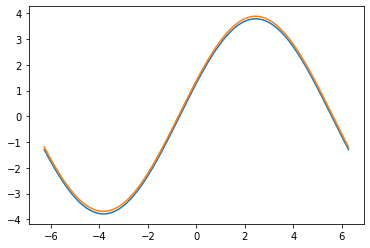

In [3]:
coeffs0=jnp.array([1, 2, 3, 4], dtype='float32') # Define coefficients
n_angles0 = int(jnp.log2(len(coeffs0))) # Number of angles is log 2 of number of coefficients.

f0 = trigonometric_sum_func(coeffs0, n_angles0) # Define function with precsribed coefficients

# Choose random y and sweep over x to compare explicit funciton and the one defined implicitly.
x_sweep = jnp.linspace(-2*jnp.pi, 2*jnp.pi, 1000)
y = 0.3

plt.plot(x_sweep, vmap(lambda x: f0(jnp.array([x, y], dtype='float32')))(x_sweep))
plt.plot(x_sweep, jnp.cos(x_sweep/2)*jnp.cos(y/2)+
         2*jnp.cos(x_sweep/2)*jnp.sin(y/2)+
         3*jnp.sin(x_sweep/2)*jnp.cos(y/2)+
         4*jnp.sin(x_sweep/2)*jnp.sin(y/2)+0.1) # SHift added for clarity.

Now let us see whether local minima are problematic for random trigonometric sums.

In [4]:
def random_trigonometric_loss(num_angles, key=random.PRNGKey(0)):
    key, subkey = random.split(key)
    unbalanced_coeffs = random.uniform(subkey, shape=(2, 2**num_angles, ), minval=0, maxval=1)
    unbalanced_coeffs = unbalanced_coeffs[0]+1j*unbalaced_coeffs[1]
    unbalanced_f = trigonometric_sum_func(unbalanced_coeffs, num_angles)
    
    key, subkey = random.split(key)
    min_angles = random_angles(num_angles, key=subkey)
    
    c0 =unbalanced_coeffs[0] - unbalanced_f(min_angles)/cos_sin_monomials(min_angles, num_angles)[0]
    balanced_coeffs = unbalanced_coeffs.at[0].set(c0)
    
    balanced_f = trigonometric_sum_func(balanced_coeffs, num_angles)
    
    return lambda angles: jnp.abs(balanced_f(angles))**2

In [198]:
%%time
num_angles = 14
loss_func = random_trigonometric_loss(num_angles, key=random.PRNGKey(5))
ah, lh = optax_minimize(loss_func, num_angles, optax.adam(0.1))

CPU times: user 14.6 s, sys: 153 ms, total: 14.8 s
Wall time: 8.57 s


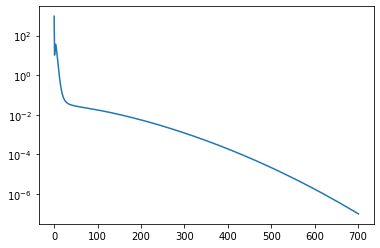

In [199]:
plt.plot(lh)
plt.yscale('log')

It appears that under 15 or so angles the local minumums are not problematic for random trigonometric functions. Going above 15 angles seems to be too expensive. However, in the next section we will find realistic examples that have local minumums and not too much parameters.

# Unitary losses

It seems that good examples of local minimum problem can be found if we take a circuit with many cnot but fix some of the angles (to bring the number of parameters down). Here is an example.

In [5]:
def insert_angles(angles, insertion_angles, indices):
    new_angles = angles
    for a, i in zip(insertion_angles, indices):
        new_angles = new_angles.at[i].set(a)
    return new_angles

def u_func_constrained(u_func, target_angles, indices):
    return lambda free_angles: u_func(insert_angles(target_angles, free_angles, indices))

Initial angles in the definition of the target can be changed with the local minimum problem being fairly robust. This way one can obtain a series of examples to test against optimization ideas.

In [234]:
%%time

anz = Ansatz(3, 'cz', fill_layers(sequ_layer(3), 4))

angles_target = random_angles(anz.num_angles, key=random.PRNGKey(1004))
u_target = anz.unitary(angles_target)

num_free_angles = 13
indices = random.choice(random.PRNGKey(100), jnp.arange(anz.num_angles), shape=(num_free_angles, ))
constrained_u = u_func_constrained(anz.unitary, angles_target, indices)

ah, lh, sh = unitary_learn_repeat(constrained_u, 
                                  u_target, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.1, 
                                  num_repeats=20, 
                                  target_loss=1e-4)

CPU times: user 3min 14s, sys: 5.59 s, total: 3min 19s
Wall time: 3min 2s


In [235]:
sum(sh)/len(sh)

0.1

# Poisson optimization

In [6]:
anz = Ansatz(3, 'cz', fill_layers(sequ_layer(3), 4))

angles_target = random_angles(anz.num_angles, key=random.PRNGKey(1004))
u_target = anz.unitary(angles_target)
pre_loss = lambda angles: trace_prod(u_target, anz.unitary(angles))

num_free_angles = 13
indices = random.choice(random.PRNGKey(100), jnp.arange(anz.num_angles), shape=(num_free_angles, ))
constrained_u = u_func_constrained(anz.unitary, angles_target, indices)
constrained_pre_loss = u_func_constrained(pre_loss, angles_target, indices)

In [7]:
# Check that pre_loss reproduces our loss
free_angles_sample = random_angles(num_free_angles)

print(disc2(u_target, constrained_u(free_angles_sample)))
print(1 - jnp.abs(constrained_pre_loss(free_angles_sample)) ** 2 / 8 ** 2)

0.99757725
0.99757725


In [8]:
coeffs_array = trigonometric_coefficients(constrained_pre_loss, num_free_angles).reshape([2]*num_free_angles)
def ABcoeffs(coeffs_array, i):
    W0 = jnp.take(coeffs_array, indices=0, axis=i)
    W1 = jnp.take(coeffs_array, indices=1, axis=i)
    A = (W0*W0.conj()-W1*W1.conj()).sum()/2
    B = (W0*W1.conj()).sum()
    return jnp.real(A), jnp.real(B)

def AB_angle(A, B):
    AB_func = lambda x: A*jnp.cos(x)+B*jnp.sin(x)
    return min_angle(AB_func)

guess_angles = jnp.array([AB_angle(*ABcoeffs(coeffs_array, i)) for i in range(num_free_angles)])

In [9]:
ah, lh, sh = unitary_learn_repeat(constrained_u, 
                                  u_target, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.1, 
                                  num_repeats=10, 
                                  target_loss=1e-4)


In [10]:
print(sum(sh)/len(sh))

0.0


[DeviceArray(5.247024, dtype=float32),
 DeviceArray(2.2169971, dtype=float32),
 DeviceArray(0.23789886, dtype=float32),
 DeviceArray(4.724446, dtype=float32),
 DeviceArray(1.8992922, dtype=float32),
 DeviceArray(1.8316195, dtype=float32),
 DeviceArray(1.5073549, dtype=float32),
 DeviceArray(5.173807, dtype=float32),
 DeviceArray(1.5073549, dtype=float32),
 DeviceArray(4.724446, dtype=float32),
 DeviceArray(1.961399, dtype=float32),
 DeviceArray(2.2169971, dtype=float32),
 DeviceArray(4.635669, dtype=float32)]

In [16]:
ah, lh = unitary_learn(constrained_u, 
                                  u_target, 
                                  anz.num_angles, 
                                  'natural adam', 
                                  0.1, 
                                  initial_params=jnp.array([angles_target[i] for i in indices])+0.01,
                                  target_loss=1e-4)


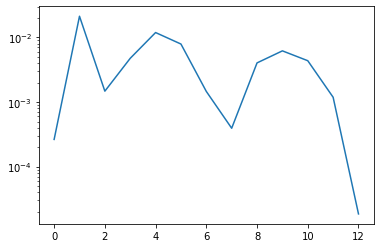

In [17]:
plt.plot(lh)
plt.yscale('log')
